# NITE regulation 

**Identifying divergence between local chromatin accessibility and gene expression**

A general assumption made in single-cell analysis (gene scoring, data integration, etc.) is that changes in local chromatin accessibility correspond to changes in gene expression. We found that assumption is frequently violated, and that when chromatin accessibiltity diverges from gene expression this has interesting implications for regulation and signaling. The next tutorial demonstrates how to use RP modeling to quantify the divergence between modes.

First, an introduction of terms:

* **L**ocal chromatin accessibility-**I**nfluenced **T**ranscriptional **E**xpression (**LITE**) model: learns a relationship between a gene and its local chromatin *only*.
* **N**on-local chromatin accessibility-**I**nfluenced **T**ranscriptional **E**xpression (**NITE**) model: extends the LITE model to relate genome-wide changes in chromatin to gene expression via the learned accessibility topics.

Since the NITE model has an expanded scope and can learn a relationship with genome-wide changes in chromatin rather than just local changes, this model is strictly better at predicting expression than the LITE model. By comparing the predictive capacity of local (LITE) vs. genome wide (NITE) chromatin changes, one can address if transcriptional regulation of a gene is modulated through local chromatin or through some other nonlocal regulatory mechanism.

By extension, one can also see if in certain cell states gene expression is more or less determined by the local chromatin landscape.

Let's import some packages:

In [1]:
import mira
import scanpy as sc
import anndata
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", size = 14)
import seaborn as sns
mira.utils.pretty_sderr()

and downloading the SHARE-seq skin dataset (if not downloaded already):

In [2]:
mira.datasets.ShareseqSkin_Ma2020()
rna_data = anndata.read_h5ad('mira-datasets/shareseq_Ma2020/rna_data.joint_representation.h5ad')
atac_data = anndata.read_h5ad('mira-datasets/shareseq_Ma2020/atac_data.joint_representation.motif_calls.tss_annotated.h5ad')

rna_model = mira.topics.ExpressionTopicModel.load('mira-datasets/shareseq_Ma2020/rna_model.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('mira-datasets/shareseq_Ma2020/atac_model.pth')

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* rna_data.joint_representation.rp_modeled.h5ad
	* hair_follicle.h5ad
	* hair_follicle.lineage_inference.h5ad
	* rna_data.joint_representation.h5ad
	* atac_data.joint_representation.h5ad
	* atac_model.pth
	* atac_data.h5ad
	* atac_data.joint_representation.motif_calls.tss_annotated.h5ad
	* atac_data.joint_representation.motif_calls.h5ad
	* rna_model.pth
	* rna_data.h5ad
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [3]:
atac_model.encoder.calc_readdepth = False

## Training NITE models

The NITE model is an extension of the LITE model, but with an awareness of the genome-wide chromatin landscape. First, we need to load in some LITE models. This cell loads the LITE models trained in the previous tutorial.

In [4]:
rp_args = dict(expr_adata = rna_data, atac_adata = atac_data)

litemodel = mira.rp.LITE_Model.load_dir(
    expr_model = rna_model, 
    accessibility_model = atac_model,
    prefix='data/rpmodels/'
)

litemodel.predict(**rp_args)

INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/56 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


Then, we can use the `spawn_NITE_model` function to initialize a NITE model object. The spawn function seeds the parameters of the NITE model with the pretrained values from the LITE model, and sets up the NITE model to reference the same topic models and genes.

In [5]:
nitemodel = litemodel.spawn_NITE_model()

Now we can fit the NITE model parameters. The API for the NITE model is identical to the LITE model. The code below fits the parameters, then predicts gene expression given the genome-wide chromatin state.

In [6]:
nitemodel.fit(**rp_args, n_workers=4).predict(**rp_args)

Fitting models:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting expression:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: NITE_prediction
INFO:mira.adata_interface.core:Added layer: NITE_logp


Saving NITE models is the same as LITE models as well:

In [7]:
nitemodel.save('data/rpmodels/')

## Chromatin differential

We define chromatin differential as the log-ratio of the LITE model prediction vs. the NITE model prediction of gene expression. When these two models predict similar values, chromatin differential is close to zero. If the LITE model over-estimates expression (say in the case of lineage priming) then chromatin differential increases. In the plots below, over-esimation is indicated in *Red*. First, calculate chromatin differential:

In [8]:
mira.tl.get_chromatin_differential(rna_data)

INFO:mira.adata_interface.core:Added layer: chromatin_differential


Now plot using `mira.pl.plot_chromatin_differential`. For each gene, the expression and local chromatin/LITE prediction are shown. Then, chromatin differential is shown with *Red* indicating the LITE model over-estimates expession compared to the all-seeing NITE model. The chromatin differential color range is the same for each gene, so we can compare its the magnitude across genes.

Finally, we plot the NITE vs. LITE predictions in a scatterplot, colored by observed expression counts. This final plot is most insteresting, and visually represents the predictive capacity of the LITE and NITE models. A simple way to read this plot is to imagine it is expression (NITE prediction) as a function of local chromatin accessibility (LITE prediction).

We can compare the LITE or NITE prediction against the gradient of observed expression to assess the goodness of fit. If most of the points are on the diagonal, then both models agree on expression rate. 

Conversely, when cells jut off the diagonal, there is disagreement between LITE and NITE models. For **KRT23** (bottom), there is a group of cells where the LITE model suggests a medium-high expression rate, but the NITE model correctly assess these cells as having low KRT expression. These cells are colored dark red on the adjacent plot.

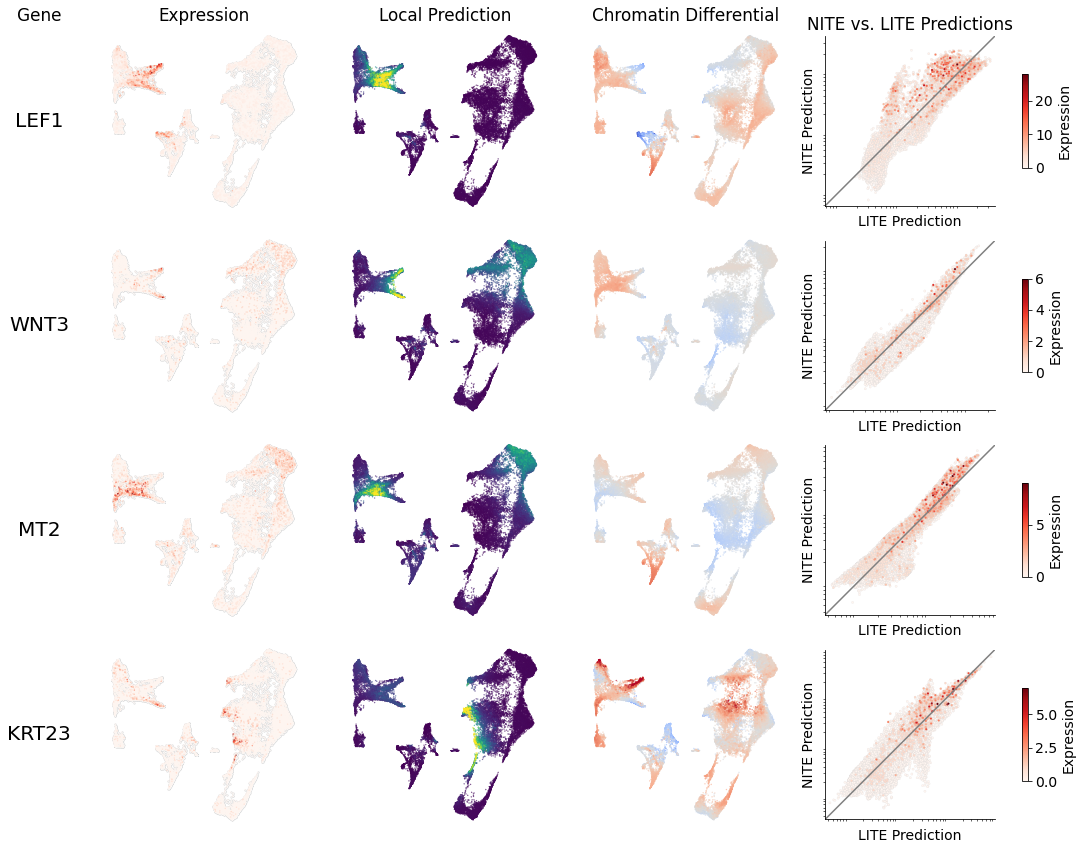

In [9]:
mira.pl.plot_chromatin_differential(rna_data, genes = litemodel.genes, 
                                    show_legend=False, size = 0.1, aspect=1.2)
plt.show()

For more granular control over the NITE vs. LITE scatterplot, use [mira.pl.plot_scatter_chromatin_differential](plotting/mira.pl.plot_scatter_chromatin_differential.html#mira.pl.plot_scatter_chromatin_differential). For example, one could plot cell types or pseudotemporal information:

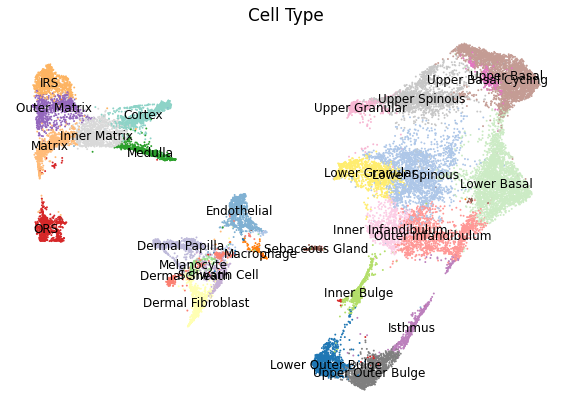

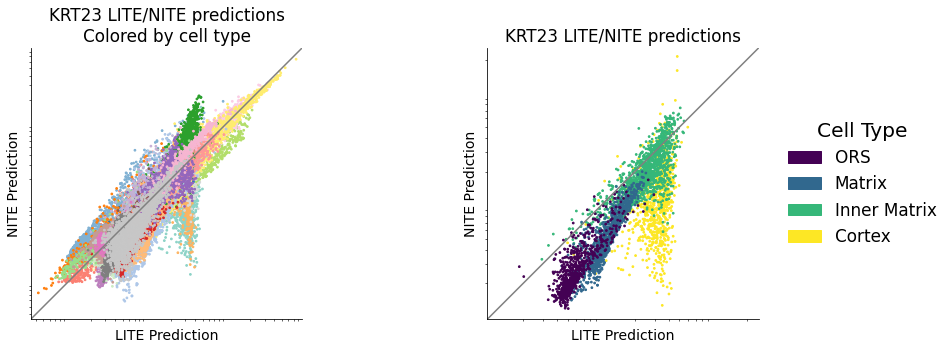

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sc.pl.umap(rna_data, color = 'true_cell', legend_loc='on data', legend_fontsize=12, size = 15,
              legend_fontweight=400, frameon=False, show=False, title = 'Cell Type',
              palette=sns.color_palette('Set3') + sns.color_palette('tab20'), ax=ax)

fig, ax = plt.subplots(1,2,figsize=(15,5))

mira.pl.plot_scatter_chromatin_differential(rna_data, gene='KRT23', color='true_cell',
                                           show_legend=False, title = 'KRT23 LITE/NITE predictions\nColored by cell type',
                                           palette=list(rna_data.uns['true_cell_colors']),
                                           hue_order = rna_data.obs.true_cell.cat.categories, ax = ax[0])

rna_data.obs['Cell Type'] = rna_data.obs.true_cell

mira.pl.plot_scatter_chromatin_differential(
    rna_data[rna_data.obs.true_cell.isin(['Cortex','Inner Matrix','Matrix','ORS'])],
    gene='KRT23', color='Cell Type',
    show_legend=True, palette='viridis',
    hue_order = ['ORS','Matrix','Inner Matrix','Cortex'],
    title = 'KRT23 LITE/NITE predictions', ax = ax[1],
)

plt.show()

## NITE scores

To quantify the difference in predictive capacity between LITE and NITE models for genes and cell states, use **NITE scores**. The NITE score is a one-number summary metric describing the statistical divergence between gene expression and local chromatin accessibility. NITE score calculation requires normalization for dropout frequency across many genes, so we will load in with precomputed predictions of many (~5000) NITE models.

In [11]:
rna_data = anndata.read_h5ad('mira-datasets/shareseq_Ma2020/rna_data.joint_representation.rp_modeled.h5ad')

In [12]:
mira.tl.get_NITE_score_cells(rna_data)
mira.tl.get_NITE_score_genes(rna_data)

INFO:mira.adata_interface.lite_nite:Added keys to obs: NITE_score, nonzero_counts
INFO:mira.adata_interface.lite_nite:Added keys to var: NITE_score, nonzero_counts


**Side note:** If you would like to conduct NITE score testing across a small number of genes (<2000), you can manually provide a measure of the median nonzero count rate across genes.

```
median_nonzero_counts = np.median(
        np.array((rna_data[:, rna_model.features].X > 0).sum(-1))
    ) # get median number of nonzero counts across genes
    
mira.tl.get_NITE_score_cells(rna_data, median_nonzero_expression=median_nonzero_counts)
mira.tl.get_NITE_score_genes(rna_data, median_nonzero_expression=median_nonzero_counts)
```

### Cell-level NITE score

Highlights cell states where local chromatin accessibility is less predictive of gene expression. We found that terminal cells often had gene expression more detached from local chromatin regulation.

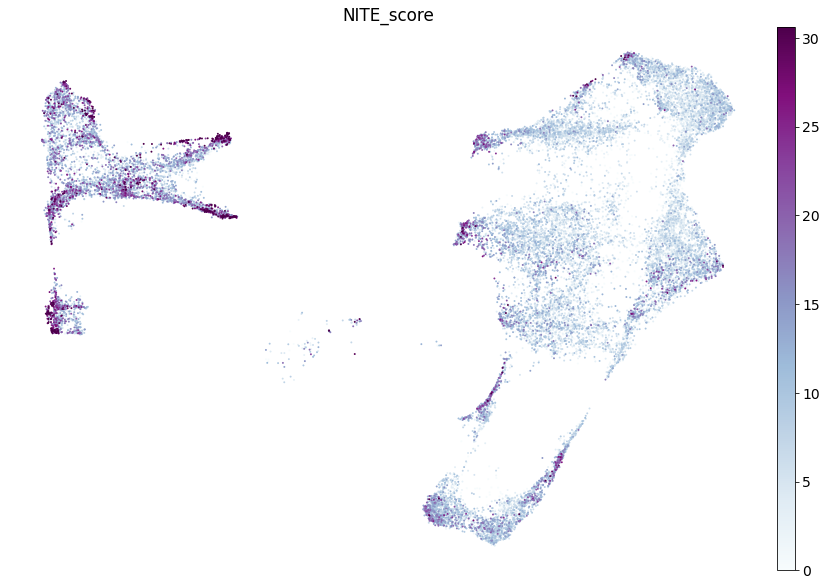

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
sc.pl.umap(rna_data, color = 'NITE_score', vmin = 0, vmax = 'p99', color_map = 'BuPu',
               frameon=False, ax= ax, size = 15)

### Gene-level NITE score

Orders genes according to how predictive their local chromatin environment is of expression. We can plot the NITE score distribution against our four example genes. **LEF1** and **KRT23** show the greatest NITE scores, reflecting that local chromatin environment doesn't predict expression levels in some cell types as per the chromatin differential plots.

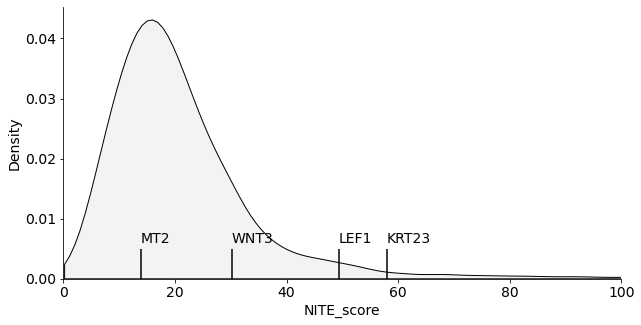

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax = sns.kdeplot(data = rna_data.var, x = 'NITE_score', fill = True,
                color = 'lightgrey', edgecolor = 'black', cut = 0 )
for i, gene in enumerate(litemodel.genes):
    nitescore = rna_data.var.loc[gene].NITE_score
    ax.vlines(nitescore, ymin = 0, ymax = 0.005, color = 'black')
    ax.text(x = nitescore, y = 0.006, s = gene)

ax.set(xlim = (0, 100))
sns.despine()

As we outline in the MIRA paper, NITE score essentially acts as a beacon for interesting regulation, as divergence of local chromatin and gene expression appears to be influenced by important processes such as signaling, lineage priming, and fate commitment. From here, we suggest investigating the regulation of high-NITE cells, and perusing for patterns in gene regulatory dynamics using chromatin differential. 

A quick place to start may be finding functional enrichments for the top most NITE-regulated genes. Using the MIRA [Enrichr API](tutorials/enrichr.html) with the top 500 most NITE genes:

In [15]:
nite_enrichments = mira.tl.fetch_ontologies(
    mira.tl.post_genelist(rna_data.var.NITE_score.dropna().sort_values().tail(500).index.values),
    ontologies=['WikiPathways_2019_Human','GO_Biological_Process_2018','BioPlanet_2019']
)

This finds terms related to hair follicle and epidermis development. We investigated the NITE regulation in these cell types in the paper. The last ontology finds enrichment of terms related to NCAM and neuronal regulation. Genes in these ontologies are expressed by the hair follicle isthmus, and may connect NITE regulation to the [timing of cyclical hair follicle remodeling](https://pubmed.ncbi.nlm.nih.gov/9815282/).

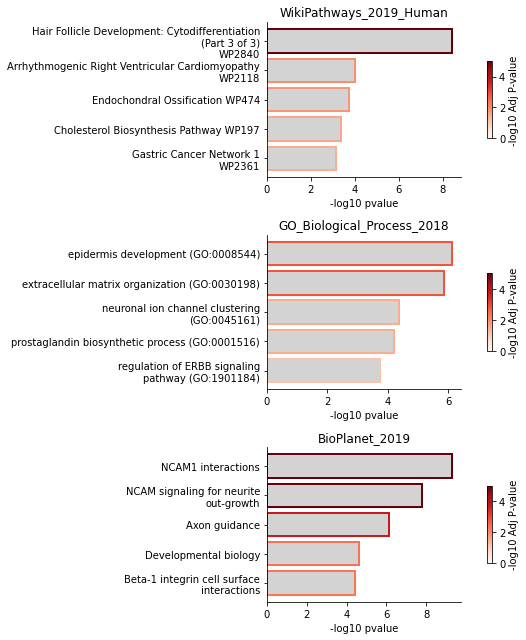

In [16]:
matplotlib.rc('font', size = 10)
mira.pl.plot_enrichments(nite_enrichments, plots_per_row=1,
                         show_genes = False, show_top = 5, 
                         aspect=2.5, height=3)

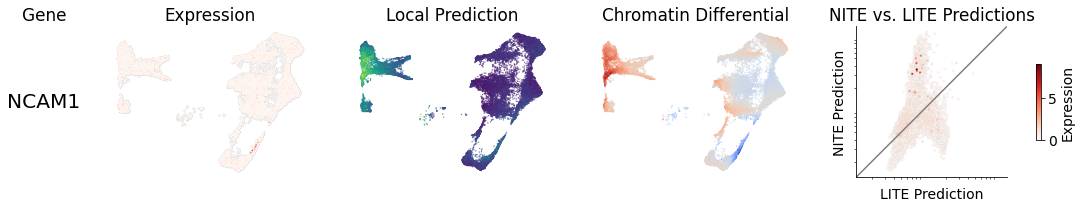

In [17]:
matplotlib.rc('font', size = 14)
mira.pl.plot_chromatin_differential(rna_data, genes = ['NCAM1'], 
                                    show_legend=False, size = 0.1, aspect=1.2)
plt.show()